# Mixture Logits Network (MLN)

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as TD
from torch.autograd import Variable
from torchvision import datasets,transforms
from collections import OrderedDict
%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=2)
torch.set_printoptions(precision=2)
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.7.0+cu101].
device:[cuda:0].


### Define the model

In [2]:
def np2tc(x_np): return torch.from_numpy(x_np).float().to(device)
def tc2np(x_tc): return x_tc.detach().cpu().numpy()

class MixtureOfLogits(nn.Module):
    def __init__(self,
                 in_dim     = 64,   # input feature dimension 
                 y_dim      = 10,   # number of classes 
                 k          = 5,    # number of mixtures
                 sig_min    = 1e-4, # minimum sigma
                 sig_max    = None, # maximum sigma
                 SHARE_SIG  = True  # share sigma among mixture
                 ):
        super(MixtureOfLogits,self).__init__()
        self.in_dim     = in_dim    # Q
        self.y_dim      = y_dim     # D
        self.k          = k         # K
        self.sig_min    = sig_min
        self.sig_max    = sig_max
        self.SHARE_SIG  = SHARE_SIG
        self.build_graph()

    def build_graph(self):
        self.fc_pi      = nn.Linear(self.in_dim,self.k)
        self.fc_mu      = nn.Linear(self.in_dim,self.k*self.y_dim)
        if self.SHARE_SIG:
            self.fc_sigma   = nn.Linear(self.in_dim,self.k)
        else:
            self.fc_sigma   = nn.Linear(self.in_dim,self.k*self.y_dim)

    def forward(self,x):
        """
            :param x: [N x Q]
        """
        pi_logit        = self.fc_pi(x)                                 # [N x K]
        pi              = torch.softmax(pi_logit,dim=1)                 # [N x K]
        mu              = self.fc_mu(x)                                 # [N x KD]
        mu              = torch.reshape(mu,(-1,self.k,self.y_dim))      # [N x K x D]
        if self.SHARE_SIG:
            sigma       = self.fc_sigma(x)                              # [N x K]
            sigma       = sigma.unsqueeze(dim=-1)                       # [N x K x 1]
            sigma       = sigma.expand_as(mu)                           # [N x K x D]
        else:
            sigma       = self.fc_sigma(x)                              # [N x KD]
        sigma           = torch.reshape(sigma,(-1,self.k,self.y_dim))   # [N x K x D]
        if self.sig_max is None:
            sigma = self.sig_min + torch.exp(sigma)                     # [N x K x D]
        else:
            sig_range = (self.sig_max-self.sig_min)
            sigma = self.sig_min + sig_range*torch.sigmoid(sigma)       # [N x K x D]
        mol_out = {'pi':pi,'mu':mu,'sigma':sigma}
        return mol_out

class MixtureLogitNetwork(nn.Module):
    def __init__(self,
                 name       = 'mln',        # name
                 x_dim      = [1,28,28],    # input dimension
                 k_size     = 3,            # kernel size
                 c_dims     = [32,64],      # conv channel dimensions
                 p_sizes    = [2,2],        # pooling sizes
                 h_dims     = [128],        # hidden dimensions
                 y_dim      = 10,           # output dimension
                 USE_BN     = True,         # whether to use batch-norm
                 k          = 5,            # number of mixtures
                 sig_min    = 1e-4,         # minimum sigma
                 sig_max    = 10,           # maximum sigma
                 mu_min     = -3,           # minimum mu (init)
                 mu_max     = +3,           # maximum mu (init)
                 SHARE_SIG  = True          
                 ):
        super(MixtureLogitNetwork,self).__init__()
        self.name       = name
        self.x_dim      = x_dim
        self.k_size     = k_size
        self.c_dims     = c_dims
        self.p_sizes    = p_sizes
        self.h_dims     = h_dims
        self.y_dim      = y_dim
        self.USE_BN     = USE_BN
        self.k          = k
        self.sig_min    = sig_min
        self.sig_max    = sig_max
        self.mu_min     = mu_min
        self.mu_max     = mu_max
        self.SHARE_SIG  = SHARE_SIG
        self.build_graph()
        self.init_param()

    def build_graph(self):
        self.layers = []
        # Conv layers
        prev_c_dim = self.x_dim[0] # input channel 
        for (c_dim,p_size) in zip(self.c_dims,self.p_sizes):
            self.layers.append(
                nn.Conv2d(
                    in_channels  = prev_c_dim,
                    out_channels = c_dim,
                    kernel_size  = self.k_size,
                    stride       = (1,1),
                    padding      = self.k_size//2
                    ) # conv
                )
            if self.USE_BN:
                self.layers.append(
                    nn.BatchNorm2d(num_features=c_dim)
                )
            self.layers.append(nn.ReLU())
            self.layers.append(
                nn.MaxPool2d(kernel_size=(p_size,p_size),stride=(p_size,p_size))
                )
            # self.layers.append(nn.Dropout2d(p=0.1))  # p: to be zero-ed
            prev_c_dim = c_dim 
        # Dense layers
        self.layers.append(nn.Flatten())
        p_prod = np.prod(self.p_sizes)
        prev_h_dim = prev_c_dim*(self.x_dim[1]//p_prod)*(self.x_dim[2]//p_prod)
        for h_dim in self.h_dims:
            self.layers.append(
                nn.Linear(
                    in_features  = prev_h_dim,
                    out_features = h_dim,
                    bias         = True
                    )
                )
            self.layers.append(nn.ReLU(True))  # activation
            self.layers.append(nn.Dropout2d(p=0.1))  # p: to be zero-ed
            prev_h_dim = h_dim
        # Final mixture of logits layer
        mol = MixtureOfLogits(
            in_dim      = prev_h_dim,  
            y_dim       = self.y_dim, 
            k           = self.k,
            sig_min     = self.sig_min,
            sig_max     = self.sig_max,
            SHARE_SIG   = self.SHARE_SIG
        )
        self.layers.append(mol)
        # Concatanate all layers
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.net.add_module(layer_name,layer)

    def forward(self,x):
        mln_out = self.net(x)
        return mln_out # mu:[N x K x D] / pi:[N x K] / sigma:[N x K x D]

    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            if isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
        # Heuristic: fc_mu.bias ~ Uniform(mu_min,mu_max)
        self.layers[-1].fc_mu.bias.data.uniform_(self.mu_min,self.mu_max)

def mln_uncertainties(pi,mu,sigma):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
    """
    # $\pi$
    mu_hat = torch.softmax(mu,dim=2) # logit to prob [N x K x D]
    pi_usq = torch.unsqueeze(pi,2) # [N x K x 1]
    pi_exp = pi_usq.expand_as(sigma) # [N x K x D]
    # softmax($\mu$) average
    mu_hat_avg = torch.sum(torch.mul(pi_exp,mu_hat),dim=1).unsqueeze(1) # [N x 1 x D]
    mu_hat_avg_exp = mu_hat_avg.expand_as(mu) # [N x K x D]
    mu_hat_diff_sq = torch.square(mu_hat-mu_hat_avg_exp) # [N x K x D]
    # Epistemic uncertainty
    epis = torch.sum(torch.mul(pi_exp,mu_hat_diff_sq), dim=1)  # [N x D]
    epis = torch.sqrt(torch.sum(epis,dim=1)) # [N]
    # Aleatoric uncertainty
    alea = torch.sum(torch.mul(pi_exp,sigma), dim=1)  # [N x D]
    alea = torch.sqrt(torch.mean(alea,dim=1)) # [N]
    # Return
    unct_out = {'epis':epis, # [N]
                'alea':alea  # [N]
                }
    return unct_out

def mace_loss(pi,mu,sigma,target):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
        :param target:  [N x D]
    """
    # $\mu$
    mu_hat = torch.softmax(mu,dim=2) # logit to prob [N x K x D]
    log_mu_hat = torch.log(mu_hat+1e-6) # [N x K x D]
    # $\pi$
    pi_usq = torch.unsqueeze(pi,2) # [N x K x 1]
    pi_exp = pi_usq.expand_as(mu) # [N x K x D]
    # target
    target_usq =  torch.unsqueeze(target,1) # [N x 1 x D]
    target_exp =  target_usq.expand_as(mu) # [N x K x D]
    # CE loss
    ce_exp = -target_exp*log_mu_hat # CE [N x K x D]
    ace_exp = ce_exp / sigma # attenuated CE [N x K x D]
    mace_exp = torch.mul(pi_exp,ace_exp) # mixtured attenuated CE [N x K x D]
    mace = torch.sum(mace_exp,dim=1) # [N x D]
    mace = torch.sum(mace,dim=1) # [N]
    mace_avg = torch.mean(mace) # [1]
    # Compute uncertainties (epis and alea)
    unct_out = mln_uncertainties(pi,mu,sigma)
    epis = unct_out['epis'] # [N]
    alea = unct_out['alea'] # [N]
    epis_avg = torch.mean(epis) # [1]
    alea_avg = torch.mean(alea) # [1]
    # Return
    loss_out = {'mace':mace, # [N]
                'mace_avg':mace_avg, # [1]
                'epis':epis, # [N]
                'alea':alea, # [N]
                'epis_avg':epis_avg, # [1]
                'alea_avg':alea_avg # [1]
                }
    return loss_out

def mln_gather(pi,mu,sigma):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
    """
    max_idx = torch.argmax(pi,dim=1) # [N]
    idx_gather = max_idx.unsqueeze(dim=-1).repeat(1,mu.shape[2]).unsqueeze(1) # [N x 1 x D]
    mu_sel = torch.gather(mu,dim=1,index=idx_gather).squeeze(dim=1) # [N x D]
    sigma_sel = torch.gather(sigma,dim=1,index=idx_gather).squeeze(dim=1) # [N x D]
    out = {'max_idx':max_idx, # [N]
           'idx_gather':idx_gather, # [N x 1 x D]
           'mu_sel':mu_sel, # [N x D]
           'sigma_sel':sigma_sel # [N x D]
           }
    return out

def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct,epis_unct_sum,alea_unct_sum = 0,0,0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            # Foraward path
            y_trgt = batch_out.to(device)
            mln_out = model.forward(batch_in.view(-1,1,28,28).to(device))
            pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
            out = mln_gather(pi,mu,sigma)
            model_pred = out['mu_sel']

            # Compute uncertainty 
            unct_out = mln_uncertainties(pi,mu,sigma)
            epis_unct = unct_out['epis'] # [N]
            alea_unct = unct_out['alea'] # [N]
            epis_unct_sum += torch.sum(epis_unct)
            alea_unct_sum += torch.sum(alea_unct)

            # Check predictions
            _,y_pred = torch.max(model_pred,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        epis = (epis_unct_sum/n_total).detach().cpu().item()
        alea = (alea_unct_sum/n_total).detach().cpu().item()
        model.train() # back to train mode 
        out_eval = {'val_accr':val_accr,'epis':epis,'alea':alea}
    return out_eval

# Demo forward path of MLN
M = MixtureLogitNetwork(k=3,SHARE_SIG=True).to(device)
x = torch.rand([2]+M.x_dim).to(device)
target = F.one_hot(torch.randint(low=0,high=10,size=(2,)),num_classes=10).to(device) 
mln_out = M.forward(x)
pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
mu_sel = mln_gather(pi,mu,sigma)['mu_sel']
loss_out = mace_loss(pi,mu,sigma,target)
loss = loss_out['mace_avg'] - loss_out['epis_avg'] # epis as a regularizer 
loss.backward() # backward propagation 
print ("x:       %s"%(tc2np(x).shape,))
print ("=>")
print ("pi:    %s\n%s"%(tc2np(pi).shape,tc2np(pi)))
print ("mu:    %s\n%s"%(tc2np(mu).shape,tc2np(mu)))
print ("sigma: %s\n%s"%(tc2np(sigma).shape,tc2np(sigma)))
print ("=>")
print ("mace:[%.3f] epis:[%.3f] alea:[%.3f]"%
       (loss_out['mace_avg'],loss_out['epis_avg'],loss_out['alea_avg']))

x:       (2, 1, 28, 28)
=>
pi:    (2, 3)
[[0.63 0.16 0.21]
 [0.29 0.69 0.02]]
mu:    (2, 3, 10)
[[[ 1.86 -4.73  0.28 -3.51  6.09 -1.77  3.52  4.2  -1.09  1.14]
  [ 0.52 -4.36  2.58 -0.27  0.24  3.42 -0.34  0.11  0.84  1.86]
  [ 2.13 -2.12 -2.09 -6.71  1.68 -1.84 -0.08 -2.23 -2.7   1.47]]

 [[ 0.49 -3.87  0.16 -3.48  4.01 -2.23  2.6   4.03 -1.78  1.97]
  [-0.8  -3.61  0.89 -1.02 -0.45  3.21  0.24  1.48 -0.58  0.52]
  [ 1.97 -3.4  -2.95 -4.28  1.77 -1.36 -2.05 -0.78 -1.49 -0.18]]]
sigma: (2, 3, 10)
[[[1.15 1.15 1.15 1.15 1.15 1.15 1.15 1.15 1.15 1.15]
  [9.81 9.81 9.81 9.81 9.81 9.81 9.81 9.81 9.81 9.81]
  [1.83 1.83 1.83 1.83 1.83 1.83 1.83 1.83 1.83 1.83]]

 [[1.53 1.53 1.53 1.53 1.53 1.53 1.53 1.53 1.53 1.53]
  [8.2  8.2  8.2  8.2  8.2  8.2  8.2  8.2  8.2  8.2 ]
  [0.82 0.82 0.82 0.82 0.82 0.82 0.82 0.82 0.82 0.82]]]
=>
mace:[3.579] epis:[0.409] alea:[2.055]


### Dataset

In [3]:
def get_train_iter(rs_rate=0.0,rp_rate=0.0,BATCH_SIZE=64):
    mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
    n_train = len(mnist_train) 
    # Random shuffle
    if rs_rate > 0:
        n_rs = int(n_train*rs_rate) 
        r_idx = np.random.permutation(n_train)[:n_rs]
        mnist_train.targets[r_idx] = torch.randint(low=0,high=10,size=(n_rs,)) # random label 
    # Random permute
    if rp_rate > 0:
        permute_labels = [1,2,3,4,5,6,7,8,9,0] 
        targets = mnist_train.targets
        sel_idxs = []
        for label in range(10):
            sel_idx = torch.where(targets==label)[0]
            sel_idxs.append(sel_idx)
        for label in range(10):
            sel_idx = sel_idxs[label]
            n_sel = sel_idx.shape[0]
            corrupt_idx = np.random.permutation(n_sel)[:int(n_sel*rp_rate)]
            mnist_train.targets[sel_idx[corrupt_idx]] = permute_labels[label]
    # Train iterator 
    train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
    return train_iter
def get_test_iter(BATCH_SIZE=64):
    mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
    test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)    
    return test_iter
print ("Done.")

Done.


### Evaluation

In [4]:
train_iter,test_iter = get_train_iter(),get_test_iter()
M = MixtureLogitNetwork(k=3,SHARE_SIG=True).to(device)
M.init_param()
train_accr = func_eval(M,train_iter,device)['val_accr']
test_accr = func_eval(M,test_iter,device)['val_accr']
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.051] test_accr:[0.051].


### Train

In [5]:
def train_wrapper(rs_rate=0.0,rp_rate=0.0,EPOCHS=10):
    np.random.seed(seed=0); torch.manual_seed(seed=0) # fix random seed
    M = MixtureLogitNetwork(name='mln',x_dim=[1,28,28],k_size=3,c_dims=[32,64],p_sizes=[2,2],
                            h_dims=[128],y_dim=10,USE_BN=False,k=5,
                            sig_min=1.0,sig_max=1.0, # not using sigma here
                            mu_min=-1,mu_max=+1,SHARE_SIG=True).to(device)
    M.init_param()
    optm = optim.Adam(M.parameters(),lr=1e-3,weight_decay=1e-6)
    M.train() # train mode
    train_iter = get_train_iter(rs_rate=rs_rate,rp_rate=rp_rate,BATCH_SIZE=128)
    test_iter = get_test_iter(BATCH_SIZE=128)
    print_every = 1
    for epoch in range(EPOCHS):
        loss_sum = 0.0
        for batch_in,batch_out in train_iter:
            # Forward path
            mln_out = M.forward(batch_in.view(-1,1,28,28).to(device)) 
            pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
            target = torch.eye(M.y_dim)[batch_out].to(device)
            loss_out = mace_loss(pi,mu,sigma,target) # 'mace_avg','epis_avg','alea_avg'
            loss = loss_out['mace_avg'] - 0.0*loss_out['epis_avg']
            # Update 
            optm.zero_grad() # reset gradient 
            loss.backward() # back-propagation 
            optm.step() # optimizer update
            # Track losses 
            loss_sum += loss
        loss_avg = loss_sum/len(train_iter)
        # Print
        if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
            train_res = func_eval(M,train_iter,device)
            test_res  = func_eval(M,test_iter,device)
            print ("epoch:[%d/%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
                (epoch,EPOCHS,loss_avg,train_res['val_accr'],test_res['val_accr'])) 
            print (" [Train] alea:[%.3f] epis:[%.3f] / [Test] alea:[%.3f] epis:[%.3f]"%
                (train_res['alea'],train_res['epis'],test_res['alea'],test_res['epis']))
    out = {'M':M,'train_iter':train_iter,'test_iter':test_iter}
    print ("Done")
    return out 
print ("Done.")

Done.


In [6]:
# train_wrapper(rs_rate=0.0,rp_rate=0.0)

In [7]:
# train_wrapper(rs_rate=0.8,rp_rate=0.0)

In [8]:
out = train_wrapper(rs_rate=0.0,rp_rate=0.4,EPOCHS=5)

epoch:[0/5] loss:[0.982] train_accr:[0.574] test_accr:[0.837].
 [Train] alea:[1.000] epis:[0.006] / [Test] alea:[1.000] epis:[0.006]
epoch:[1/5] loss:[0.767] train_accr:[0.594] test_accr:[0.910].
 [Train] alea:[1.000] epis:[0.002] / [Test] alea:[1.000] epis:[0.002]
epoch:[2/5] loss:[0.731] train_accr:[0.602] test_accr:[0.917].
 [Train] alea:[1.000] epis:[0.001] / [Test] alea:[1.000] epis:[0.001]
epoch:[3/5] loss:[0.714] train_accr:[0.605] test_accr:[0.906].
 [Train] alea:[1.000] epis:[0.001] / [Test] alea:[1.000] epis:[0.001]
epoch:[4/5] loss:[0.702] train_accr:[0.603] test_accr:[0.775].
 [Train] alea:[1.000] epis:[0.001] / [Test] alea:[1.000] epis:[0.001]
Done


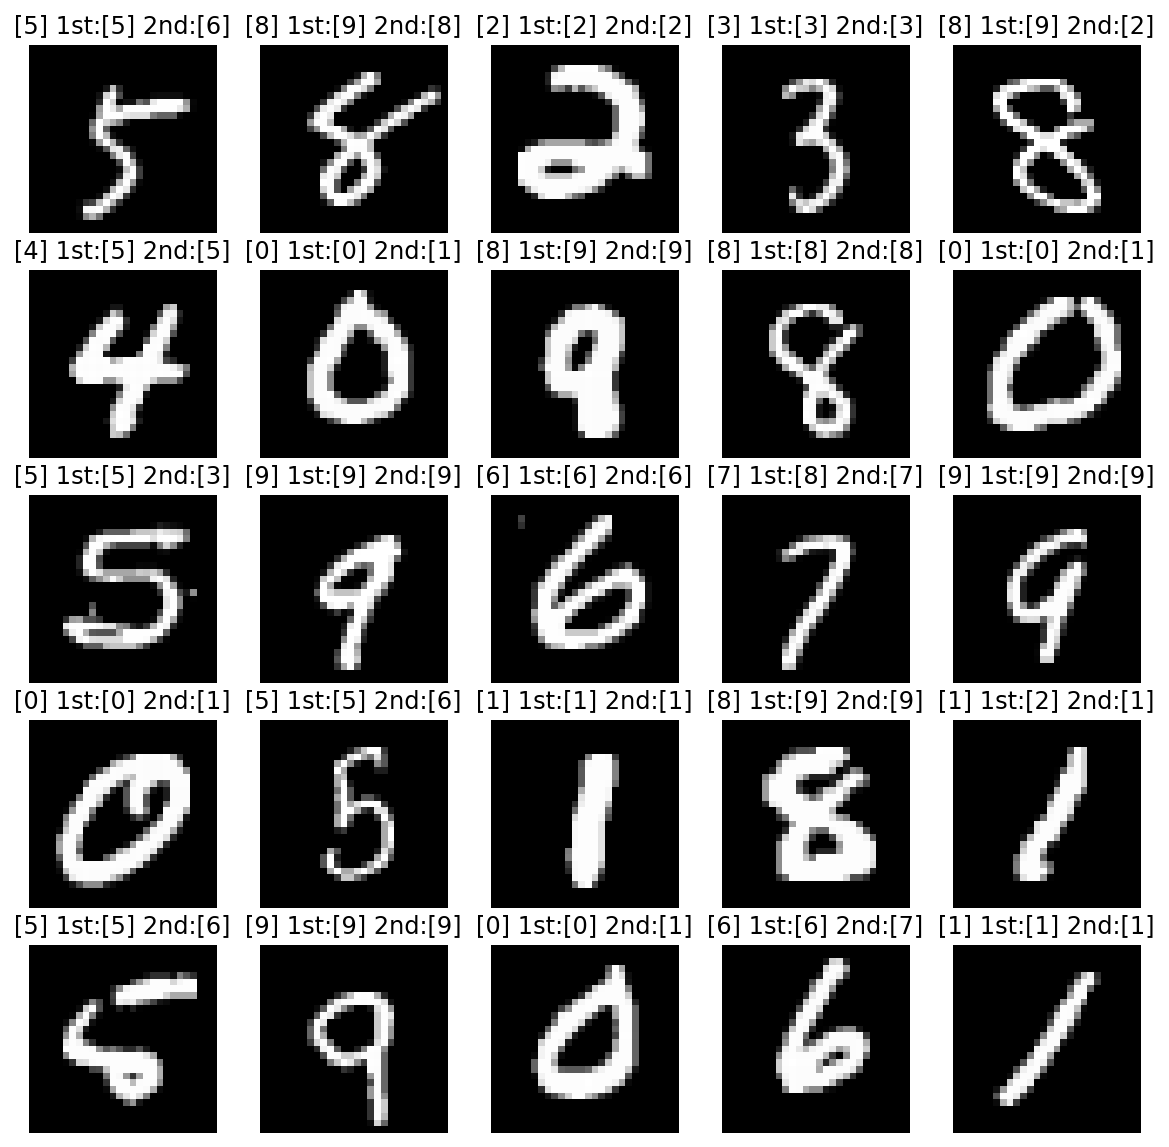

In [9]:
M = out['M']
test_iter,train_iter = out['test_iter'],out['train_iter']

mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]

x = test_x.view(-1,1,28,28).type(torch.float).to(device)/255.
mln_out = M.forward(x)
pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
target = torch.eye(M.y_dim)[test_y].to(device)
loss_out = mace_loss(pi,mu,sigma,target) # 'mace_avg','epis_avg','alea_avg'
y_pred = mln_gather(pi,mu,sigma)['mu_sel']
y_pred = y_pred.argmax(axis=1)

# Get the second-best prediction
y_pred = []
y_second = []
pi_np,mu_np,sigma_np = tc2np(pi),tc2np(mu),tc2np(sigma)
for idx in range(n_sample):
    pi_i,mu_i = pi_np[idx,:],mu_np[idx,:]
    sort_idx = np.argsort(-pi_i)
    y_pred.append(np.argmax(mu_i[sort_idx[0]]))
    y_second.append(np.argmax(mu_i[sort_idx[1]]))

# Plot results
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("[%d] 1st:[%d] 2nd:[%d]"%
              (test_y[idx],y_pred[idx],y_second[idx]))
plt.show()    


In [10]:
loss_out

{'alea': tensor([1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00,
         1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00,
         1.00], device='cuda:0', grad_fn=<SqrtBackward>),
 'alea_avg': tensor(1., device='cuda:0', grad_fn=<MeanBackward0>),
 'epis': tensor([3.83e-05, 1.36e-03, 1.49e-04, 3.54e-04, 1.37e-05, 9.78e-06, 1.40e-04,
         3.94e-03, 2.10e-05, 1.24e-04, 1.04e-04, 6.96e-05, 1.73e-03, 1.59e-02,
         1.95e-04, 8.38e-05, 9.79e-04, 8.31e-05, 1.33e-03, 9.63e-05, 2.50e-04,
         1.31e-05, 5.75e-04, 1.23e-04, 1.50e-05], device='cuda:0',
        grad_fn=<SqrtBackward>),
 'epis_avg': tensor(0.00, device='cuda:0', grad_fn=<MeanBackward0>),
 'mace': tensor([0.38, 0.86, 0.52, 0.44, 0.74, 0.73, 0.60, 2.89, 0.58, 0.62, 0.55, 0.49,
         0.38, 0.88, 0.42, 0.42, 0.63, 0.56, 0.82, 0.74, 0.29, 0.43, 0.58, 0.49,
         0.43], device='cuda:0', grad_fn=<SumBackward1>),
 'mace_avg': tensor(0.66, device='cuda:0', grad_fn=<MeanBackwar

In [11]:
pi

tensor([[1.00e+00, 1.46e-11, 3.69e-12, 1.89e-09, 6.11e-12],
        [1.00e+00, 3.37e-07, 1.31e-06, 9.90e-07, 6.35e-07],
        [1.00e+00, 1.57e-08, 1.55e-07, 5.40e-07, 1.79e-08],
        [1.00e+00, 2.67e-08, 5.53e-09, 7.50e-07, 9.65e-09],
        [1.00e+00, 1.72e-10, 4.39e-11, 2.07e-10, 4.00e-12],
        [1.00e+00, 2.17e-12, 3.81e-11, 7.06e-11, 8.82e-11],
        [1.00e+00, 1.40e-09, 4.01e-08, 8.06e-08, 9.25e-09],
        [1.00e+00, 7.87e-06, 1.03e-05, 1.81e-05, 9.44e-06],
        [1.00e+00, 9.87e-10, 5.81e-11, 4.63e-10, 1.30e-11],
        [1.00e+00, 5.60e-09, 8.72e-09, 9.70e-09, 9.18e-09],
        [1.00e+00, 7.17e-10, 6.04e-11, 1.36e-08, 1.47e-10],
        [1.00e+00, 1.19e-09, 3.94e-09, 2.01e-08, 6.09e-11],
        [1.00e+00, 1.51e-07, 8.94e-07, 2.20e-05, 4.09e-07],
        [9.99e-01, 1.03e-04, 4.13e-04, 1.09e-04, 4.88e-05],
        [1.00e+00, 2.55e-08, 4.99e-08, 1.60e-07, 2.87e-09],
        [1.00e+00, 8.07e-10, 6.23e-09, 7.68e-09, 2.07e-08],
        [1.00e+00, 2.40e-07, 2.13e-08, 2